# Processing Capacities Germany for Balmorel from OPSD

>__*Python version 3.6*__
>
> Author: [tilseb](tilseb@dtu.dk)
>
> Date: 2018-05-29

## Content
- Script setup
- Make directories
- Download data from opsd
- Read input data
- Suspect powerplants
- Specific technology naming translation
- Heat-only re-aggregation
- Balmorel wording
- Lifetime
- Balmorel regions
- Capacities
- Temporary storing of dataframes
- Aggregation
- Output: district heating
- Efficiency
- Grouping: technology, efficiency and region
- Clean-up for output
- Write output files
- Plotting of fuel stock
- Clean-up for final output
- G output
- GKFX output
- CCC, RRR, AAA output
- Comparison of results

## Script Setup

In [143]:
# Import required packages
import os
import pickle
import urllib.request
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Make Directories

In [144]:
# Make input and ouput directories
dirs = ['input', 'output', 'output/figures', 'output/tables']
for i in dirs:
    if not os.path.isdir(i):
        os.makedirs(i)

## Download Data from OPSD

### Conventional Power Plants
Source: https://data.open-power-system-data.org/conventional_power_plants/

Download: *conventional_power_plants_DE.csv*

In [145]:
# Download opsd conventional data
url = 'https://data.open-power-system-data.org/conventional_power_plants/2018-02-27/conventional_power_plants_DE.csv'
# url = 'https://data.open-power-system-data.org/conventional_power_plants/2018-12-20/conventional_power_plants_DE.csv'
filename = 'conventionals.csv'
filepath = os.path.join('input', filename)

if not os.path.exists(filepath):
    urllib.request.urlretrieve(url, filepath)
else:
    print('Using local file from ' + filepath + '.')

Using local file from input\conventionals.csv.


### Renewable Power Plants
Source: https://data.open-power-system-data.org/renewable_power_plants/

Download: *renewable_power_plants_DE.csv*

In [146]:
# Download opsd conventional data
url = 'https://data.open-power-system-data.org/renewable_power_plants/2018-03-08/renewable_power_plants_DE.csv'  
filename = 'renewables.csv'
filepath = os.path.join('input', filename)

if not os.path.exists(filepath):
    urllib.request.urlretrieve(url, filepath)
else:
    print('Using local file from ' + filepath + '.')

Using local file from input\renewables.csv.


## Read Input Data

### Conventional Power Plants

In [147]:
# Read conventional power plants
con = pd.read_csv('input/conventionals.csv',
                  encoding='utf8',
                  header=0)

# Fill empty cells in the chp column with 'no'
con.chp.fillna(value='no', inplace=True)

### Renwable Power Plants

In [148]:
# Read renewable capacities
ren = pd.read_csv('input/renewables.csv',
                  encoding='UTF8',
                  header=0,
                  parse_dates=[1],
                  dtype={'postcode': str},
                  low_memory=False)

### Specific Technology Name Translation

In [149]:
# Read specific tec translation
tec_translation = pd.read_csv('input/tec_acronyms_spec.csv',
                              encoding='utf8')

### Technology Names

In [150]:
# Read acronyms for technologies
tec = pd.read_csv('input/tec_acronyms.csv',
                  encoding='utf8',
                  header=0)

### Fuel Names

In [151]:
# Read acronyms for fuels
fuel = pd.read_csv('input/fuel_acronyms.csv',
                   encoding='UTF8',
                   header=0)

### Lifetime
1. Source: https://ens.dk/sites/ens.dk/files/Analyser/update_-_technology_data_catalogue_for_energy_plants_-_aug_2016.pdf
> Assumption: It's the technical lifetime and depending on the commissioning year.

2. Source: Nuclear phase-out data, tab. 22 on p. 172: https://www.iea.org/publications/freepublications/publication/Germany2013_free.pdf

In [152]:
# Read lifetime data for power plants
lifetime = pd.read_csv('input/lifetimes.csv',
                       encoding='UTF8',
                       header=0)

# Set dtype of the years to float
lifetime.loc['2015':'2050'] = lifetime.loc['2015':'2050'].astype(float)


# Read nuclear lifetime data
lifetime_nuclear = pd.read_csv('input/lifetimes_nuclear.csv',
                               encoding='UTF8',
                               header=0)

### Regions
Source: Data for postal codes to federal state translation: https://www.suche-postleitzahl.org/downloads

Download: *zuordnung_plz_ort*

In [153]:
# Read the german address-postcode to grid region to balmorel region translation
region_zip_grid = pd.read_csv('input/region_zip_grid.csv',
                              encoding='UTF8',
                              header=0,
                              dtype={'zip_code': str})

In [154]:
# Read the non-german address-postcode to grid region to balmorel region translation
region_zip_grid_non_DE = pd.read_csv('input/region_zip_grid_international.csv',
                                     encoding='UTF8',
                                     header=0,
                                     dtype={'zip_code': str})

In [155]:
# Read the region-choice file for balmorel-region aggregation
region_agg = pd.read_csv('input/region_aggregation.csv',
                         encoding='UTF8',
                         header=0)

In [156]:
# Read the federal-state to address-postcode translation
region_fs_zip = pd.read_csv('input/region_zip_federalstate.csv',
                            encoding='UTF8',
                            header=0,
                            dtype={'zip_code': str})

### Heat Only
1. Source: https://www.agfw.de/zahlen-und-statistiken/agfw-hauptbericht/

    >Download: *Download der öffentlichen Variante Hauptbericht 2016*

2. Source: Data for total dh demand: https://www.ag-energiebilanzen.de/

    >Download: *Energieverbrauch in Deutschland im Jahr 2017* (pg. 36)

In [157]:
# Read installed capacities of heat only plants
ho_cap = pd.read_csv('input/cap_heatonly.csv',
                     encoding='UTF8',
                     header=0,
                     skiprows=[1])

# Read fuel shares of heat only plants
ho_fuel = pd.read_csv('input/fuel_heatonly.csv',
                      encoding='UTF8',
                      header=0)

### Offshore

Source: http://www.erneuerbare-energien.de/EE/Navigation/DE/Technologien/Windenergie-auf-See/Offshore-Projekte/Netzanbindungen/netzanbindungen.html

#### Identifier

In order to extract missing information on the grid connection points of offshore wind farms in the north sea. Therefore a eeg_id_identifier filters the eeg_ids.

In [158]:
# Read eeg_id_identifier
offshore_id = pd.read_csv('input/offshore_identifier.csv',
                          encoding='UTF8')

#### Planned Capacities

Adding offshore capacities to the opsd_ren table.

In [159]:
# Read planned offshore capacities
off_fut = pd.read_csv('input/cap_offshore_planned.csv',
                      encoding='UTF8')

### Colors

Assign a color to each fuel for the plots.

In [160]:
# Read color data
colors = pd.read_csv('input/fuel_colors.csv',
                     encoding='UTF8')

## Suspect Powerplants
A powerplant is considered a suspect entry, when its comment cell is NOT empty. Those entries wont be considered.

Check https://github.com/Open-Power-System-Data/renewable_power_plants/blob/2017-06-26/main.ipynb (*5.3: validation Marker*) for more information.

In [161]:
# Check, whether suspicios entries exist for opsd_con
con.comment.unique()

array([nan])

In [162]:
# Check, whether suspicios entries exist for opsd_ren
ren.comment.unique()

array([nan])

In [163]:
# Locate suspect entries for opsd_con and opsd_ren
idx_con_suspect = con[con.comment.isnull() == False].index
idx_ren_suspect = ren[ren.comment.isnull() == False].index

# Create new opsd_ren dataframe without suspect entries
con.drop(idx_con_suspect, inplace=True)
ren.drop(idx_ren_suspect, inplace=True)

In [164]:
# Check, whether suspicios entries exist for the clean opsd_con
con.comment.unique()

array([nan])

In [165]:
# Check, whether suspicios entries exist for the clean opsd_ren
ren.comment.unique()

array([nan])

## Specific Technology Naming Translation

Some technology types have to be translated to a different one.

In [166]:
# Make a new columns in opsd_con
con['new_technology'] = con.id

# Make a dictionary from id to opsd_technology_new
dict_tec_trans = tec_translation[['id','opsd_technology_new']].set_index('id')['opsd_technology_new'].to_dict()

# Apply the dict_tec_trans
con['new_technology'].replace(dict_tec_trans, inplace=True)

In [167]:
# Over-write old by new tachnologies, if a technology name is in the new_technology column
con['technology'] = np.where(con.id != con.new_technology, con.new_technology, con.technology)

## Heat Only Re-Aggregation
Data about heat-only powerplants comes from a different source than the opsd data. The information is allready aggregated on federal state level, which differs from the grid_id aggregation. Thus, the aggregated capacities are partitioned evenly on postcode level and subsequently re-aggregated to the grid_ids.

In [168]:
# Make a new column in ho_fuel with vaules of the federal state column
ho_fuel['capacity'] = ho_fuel['federal_state']

# Make a dictionary from federal state to fuel-input-capacity
ho_cap_dict = ho_cap[['federal_state','ho_capacity']].set_index('federal_state')['ho_capacity'].to_dict()


# Replace the federal state values of the fuel input capacity column by the fuel input capacity
ho_fuel['capacity'].replace(ho_cap_dict, inplace=True)

In [169]:
# Make a new column with the fuel capacity share
ho_fuel['fuel_capacity_share'] = ho_fuel['average_efficiency_2017'] * ho_fuel['fuel_share_gross']
ho_fuel['fuel_capacity_share'] = ho_fuel.groupby(['federal_state'])['fuel_capacity_share'].transform(lambda x: x / x.sum())
ho_fuel['fuel_capacity_share'] = ho_fuel['fuel_capacity_share'] * ho_fuel['capacity']

In [170]:
# Merge ho_fuel and the federal state to postcode translation to a new dataframe called ho
ho = region_fs_zip.merge(ho_fuel, how='outer', left_on='federal_state', right_on='federal_state')

In [171]:
# Drop rows with nans in the zip_capacity_share column
ho.dropna(subset=['fuel_share_gross'], inplace=True)

In [172]:
# Calculate capacity share for each postcode
ho['zip_capacity_share'] = ho.groupby(['federal_state',
                                       'balmorel_fuel'])['fuel_capacity_share'].transform(lambda x: x.mean() / x.count())

### District Heating Demand

In [173]:
# Create new dataframe for dh demand
dh = ho_cap[['federal_state','net_dh_demand']]

In [174]:
# Merge dh and the federal state to postcode translation to a new dataframe called again dh
dh = region_fs_zip.merge(dh, how='outer', left_on='federal_state', right_on='federal_state')

In [175]:
# Calculate dh demand share for each postcode
dh['zip_dh_share'] = dh.groupby(['federal_state'])['net_dh_demand'].transform(lambda x: x.mean() / x.count())

In [176]:
# Drop rows with nans in the zip_dh_share column
dh.dropna(subset=['zip_dh_share'], inplace=True)

## Balmorel Wording

### Technology

In [177]:
# Make new ren and con columns in the tec_acronyms table
tec['tec_con_dict'] = tec['opsd_technology_conventional']
tec['tec_ren_dict'] = tec['opsd_technology_renewable']

# Combine the information about technology and chp for con
tec['tec_con_dict'] = tec['tec_con_dict'].astype(str).str.cat(tec['opsd_chp'].astype(str), sep=' chp_')
tec['tec_ren_dict'] = tec['tec_ren_dict'].astype(str).str.cat(tec['opsd_chp'].astype(str), sep=' chp_')

#### Conventional

In [178]:
# Make new column in the opsd_con table
con['balmorel_tec_group'] = con['technology']
con['balmorel_tec_type'] = con['technology']

# Combine the information about technology and chp
con['balmorel_tec_group'] = con['balmorel_tec_group'].astype(str).str.cat(con['chp'].astype(str), sep=' chp_')
con['balmorel_tec_type'] = con['balmorel_tec_type'].astype(str).str.cat(con['chp'].astype(str), sep=' chp_')

In [179]:
# Make an index for the ones that have a technology in the opsd_technology_conventional column in tec_acronyms
idx_tec_con = tec[(tec['opsd_technology_conventional'].notnull())].index

# Reduce the table for the dictionary to these ones
tec_con_no_nan = tec.loc[idx_tec_con,:]

In [180]:
# Make a conventional dictionary
dict_tec_group_con = tec_con_no_nan[['tec_con_dict','balmorel_tec_group']].set_index('tec_con_dict')['balmorel_tec_group'].to_dict()
dict_tec_type_con = tec_con_no_nan[['tec_con_dict','balmorel_tec_type']].set_index('tec_con_dict')['balmorel_tec_type'].to_dict()

# Replace in the balmorel_technology column in opsd_con the dict_tec_con by the balmorel acronym
con['balmorel_tec_group'].replace(dict_tec_group_con, inplace=True)
con['balmorel_tec_type'].replace(dict_tec_type_con, inplace=True)

#### Renewable

In [181]:
# Assign the energy-source-level 2 to empty cells in the technology column
ren.loc[ren.technology.isnull()==True, 'technology'] = ren['energy_source_level_2']

In [182]:
# Make new column in the opsd_ren table
ren['balmorel_tec_group'] = ren['technology']
ren['balmorel_tec_type'] = ren['technology']

# Make a new column for information about chp
ren.loc[(ren.thermal_capacity > 0) & (ren.electrical_capacity > 0), 'opsd_chp'] = 'yes'
ren.loc[ren.opsd_chp != 'yes', 'opsd_chp'] = 'no'

# Combine the information about technology and chp
ren['balmorel_tec_group'] = ren['balmorel_tec_group'].astype(str).str.cat(ren['opsd_chp'].astype(str), sep=' chp_')
ren['balmorel_tec_type'] = ren['balmorel_tec_type'].astype(str).str.cat(ren['opsd_chp'].astype(str), sep=' chp_')

In [183]:
# Make an index for the ones that have a technology in the opsd_technology_renewable column in tec_acronyms
idx_tec_ren = tec[(tec['opsd_technology_renewable'].notnull())].index

# Reduce the table for the dictionary to these ones
tec_ren_no_nan = tec.loc[idx_tec_ren,:]

In [184]:
# Make a renewable dictionary
dict_tec_group_ren = tec_ren_no_nan[['tec_ren_dict','balmorel_tec_group']].set_index('tec_ren_dict')['balmorel_tec_group'].to_dict()
dict_tec_type_ren = tec_ren_no_nan[['tec_ren_dict','balmorel_tec_type']].set_index('tec_ren_dict')['balmorel_tec_type'].to_dict()

# Replace in the balmorel_technology column in opsd_ren the dict_tec_ren by the balmorel acronym
ren['balmorel_tec_group'].replace(dict_tec_group_ren, inplace=True)
ren['balmorel_tec_type'].replace(dict_tec_type_ren, inplace=True)

In [185]:
# Make a new column in off_fut
off_fut['balmorel_tec_group'] = 'Offshore chp_no'
off_fut['balmorel_tec_type'] = 'Offshore chp_no'

# Replace in the values by the balmorel acronyms
off_fut['balmorel_tec_group'].replace(dict_tec_group_ren, inplace=True)
off_fut['balmorel_tec_type'].replace(dict_tec_type_ren, inplace=True)

### Fuels

In [186]:
# Make new column in the fuel_acronyms table
fuel['fuel_dict'] = np.nan

In [187]:
# Fill nans in the fuel_acronyms table with the least high energy source level
for i in range(2, fuel.shape[1]):
    fuel[fuel.columns[i]].fillna(value=fuel[fuel.columns[i - 1]], inplace=True)

In [188]:
# Make the fuel dictionary
dict_fuel = fuel[['fuel_dict','balmorel_fuel']].set_index('fuel_dict')['balmorel_fuel'].to_dict()

#### Conventional

In [189]:
# Fill nans in energy source level 2 in the opsd_con table with energy source level 1
con['energy_source_level_2'].fillna(value=con['energy_source_level_1'], inplace=True)

# Fill nans in energy source level 3 in the opsd_con table with energy source level 2
con['energy_source_level_3'].fillna(value=con['energy_source_level_2'], inplace=True)

In [190]:
# Make a new column in the conventional table
con['balmorel_fuel'] = con['energy_source_level_3']

In [191]:
# Replace all missing values with the initital opsd_fuel
con['balmorel_fuel'].fillna(value=con['fuel'], inplace=True)

# Replace in the opsd_con table the fuel_dict column by the balmorel acronyms
con['balmorel_fuel'].replace(dict_fuel, inplace=True)

In [192]:
# Delete the rows with nans in the balmorel_fuel column for opsd_con
con = con.dropna(subset=['balmorel_fuel'])

#### Renewable

In [193]:
# Fill nans in energy source level 2 in the opsd_ren table with energy source level 1
ren['energy_source_level_2'].fillna(value=ren['energy_source_level_1'], inplace=True)

# Fill nans in energy source level 3 in the opsd_ren table with energy source level 2
ren['energy_source_level_3'].fillna(value=ren['energy_source_level_2'], inplace=True)

In [194]:
# Make a new column in the renewable table
ren['balmorel_fuel'] = ren['energy_source_level_3']

In [195]:
# Replace in the opsd_ren table the fuel_dict column by the balmorel acronyms
ren = ren.assign(balmorel_fuel = ren.loc[:,'balmorel_fuel'].map(lambda x: dict_fuel.get(x, x)))

In [196]:
# Delete the rows with nans in the balmorel_fuel column for opsd_ren
ren = ren.dropna(subset=['balmorel_fuel'])

#### Offshore

In [197]:
# Make a new column in off_fut
off_fut['balmorel_fuel'] = 'Wind'

# Replace the values by the balmorel acronyms
off_fut['balmorel_fuel'].replace(dict_fuel, inplace=True)

#### Pumped storages

## Lifetime

### Conventional

In [198]:
# Make a new column in the lifetime table
lifetime['lifetime_con_dict'] = lifetime['opsd_technology_conventional']

# Combine the information about technology, chp and fuel
lifetime['lifetime_con_dict'] = lifetime['lifetime_con_dict'].astype(str).str.cat(lifetime.opsd_chp.astype(str), sep=' chp_')
lifetime['lifetime_con_dict'] = lifetime['lifetime_con_dict'].astype(str).str.cat(lifetime.opsd_fuel.astype(str), sep='_')

In [199]:
# Make an index for the ones that have a technology in the opsd_technology_conventional column in opsd_con
idx_lifetime_con = lifetime[(lifetime['opsd_technology_conventional'].notnull())].index

# Reduce the table for the dictionary to these ones
lifetime_con = lifetime.loc[idx_lifetime_con,:]

In [200]:
# Make the conventional lifetime dictionary
con_dict_lifetime = lifetime_con[['lifetime_con_dict',
                                  'lifetime_2015']].set_index('lifetime_con_dict')['lifetime_2015'].to_dict()

In [201]:
# Make new columns in the opsd_con table and combine the information about technology, chp and fuel
con['lifetime_2015'] = con['technology']
con['lifetime_2015'] = con['lifetime_2015'].astype(str).str.cat(con['chp'].astype(str), sep=' chp_')
con['lifetime_2015'] = con['lifetime_2015'].astype(str).str.cat(con['fuel'].astype(str), sep='_')

In [202]:
# Replace in the opsd_con table the lt columns by the conventional lifetime dictionary
con['lifetime_2015'].replace(con_dict_lifetime, inplace=True)

In [203]:
con[con.commissioned.isnull()==True].capacity_net_bnetza.sum()

41.2

In [204]:
# Fill shutdown column with sum of commissioning year and the technical lifetime expectency
con = con.assign(shutdown = con['commissioned'] + con['lifetime_2015'])

#### Special Case Old Plants

In [205]:
# Artificial lifetime prolongation for old plants: shutdown before 2016
# The earliest shutdown daten and 2016 unfold an interval that is cut into ten equal sub-intervals
# to classify the powerplants new shutdown date: 1st -> 2019, 2nd -> 2020, ... , 10th -> 2029
j = 2019
for i in np.linspace(min(con.shutdown), 2016, 11, endpoint=True).round(0).astype(int):
    con.loc[(con['shutdown'] < i), 'shutdown'] = j
    j += 1

#### Special Case Coal

In [206]:
# Artificial lifetime shortening for new coal fired powerplants: commissioned from 2010 onwards
# Motivation: no coal from 2050 onwards
# 2010 and the latest commission date unfold an interval that is cut into ten equal sub-intervals
# To classify the powerplants new shutdown date: 1st -> 2040, 2nd -> 2041, ... , 10th -> 2049
j = 2040
for i in np.linspace(2009, max(con.commissioned), 10, endpoint=True).round(0).astype(int):
    con.loc[(con['commissioned'] > i) & (con['balmorel_fuel'] == 'COAL'), 'shutdown'] = j
    con.loc[(con['commissioned'] > i) & (con['balmorel_fuel'] == 'LIGN'), 'shutdown'] = j
    j += 1

#### Special Case Nuclear

In [207]:
# For the nuclear powerplants in the opsd_con table fill the shutdown column with their id's
con['shutdown'] = np.where(con['fuel'] == 'Nuclear', con['id'], con['shutdown'])

In [208]:
# Create a nuclear lifetime dictionary
nuclear_dict = lifetime_nuclear[['opsd_id','balmorel_shutdown']].set_index('opsd_id')['balmorel_shutdown'].to_dict()

In [209]:
# Replace the nuclear powerplant ids in the shutdown column with the phase-out date of the nuclear dictionary
con['shutdown'].replace(nuclear_dict, inplace=True)

### Renewable Lifetime

In [210]:
# Make a new column in the lifetime table
lifetime['lifetime_ren_dict'] = lifetime['opsd_technology_renewable']

In [211]:
# Make an index for the ones that have a technology in the opsd_technology_renewable column in opsd_ren
idx_lifetime_ren = lifetime[(lifetime['opsd_technology_renewable'].notnull())].index

# Reduce the table for the dictionary to these ones
lifetime_ren = lifetime.loc[idx_lifetime_ren,:]

In [212]:
# Make the renewable lifetime dictionary
ren_dict_lifetime = lifetime_ren[['lifetime_ren_dict',
                                  'lifetime_2015']].set_index('lifetime_ren_dict')['lifetime_2015'].to_dict()

In [213]:
# Make new a column and replace in the opsd_ren table the lt columns by the renewable lifetime dictionary
ren = ren.assign(lifetime_2015 = ren.loc[:,'technology'].map(lambda x: ren_dict_lifetime.get(x, x)))

In [214]:
# Create commissioned and shutdown columns in opsd_ren
ren['commissioned'] = pd.DatetimeIndex(ren['commissioning_date']).year
ren['shutdown'] = pd.DatetimeIndex(ren['decommissioning_date']).year

In [215]:
# Fill the renewable shutdown columns with regard to the year of commissioning
ren['shutdown'] = ren['shutdown'].fillna(value=0)

In [216]:
# Fill shutdown column with sum of commissioning year and the technical lifetime expectency
ren = ren.assign(shutdown = ren['commissioned'] + ren['lifetime_2015'])

In [217]:
# Make a new technology and lifetime columns in off_fut
off_fut['technology'] = 'Offshore'
off_fut['lifetime_2015'] = 'Offshore'

# Replace the values by the renewable lifetime dictionary
off_fut['lifetime_2015'].replace(ren_dict_lifetime, inplace=True)

In [218]:
# Create commissioned and shutdown columns in off_fut
off_fut['commissioned'] = off_fut['commissioning_year']
off_fut['shutdown'] = off_fut['commissioning_year']

# Fill shutdown column with sum of commissioning year and the technical lifetime expectency
off_fut = off_fut.assign(shutdown = off_fut['commissioned'] + off_fut['lifetime_2015'])

### Heat-Only

The lifetime of heat only powerplants (boilers) is estimated to 40 years. It is directly applied in the **capacity** section.

## Balmorel Regions

In [219]:
# Function to find nearest postcode neighbours, if postcode is missing in the translation table
array = np.array(pd.to_numeric(region_zip_grid['zip_code']))

def find_nearest(array, value):
    x = int(value)
    idx = (np.abs(array - x)).argmin()
    return array[idx]

In [220]:
# Make dictionaries from postcodes for DE and non_DE to grid region
dict_zip_grid = region_zip_grid[['zip_code','grid_id']].set_index('zip_code')['grid_id'].to_dict()
dict_zip_grid_non_DE = region_zip_grid_non_DE[['zip_code','grid_id']].set_index('zip_code')['grid_id'].to_dict()

### Conventional

In [221]:
# Assign not existing german postcodes in opsd_con to the nearest postcode number of the translation dictionary
con_values = con[(con['postcode'].isin(dict_zip_grid) == False) & (con['postcode'].str.isdigit() == True)].postcode
           
for i in con_values:
    con.loc[con.postcode == i, 'postcode'] = find_nearest(array, i)

In [222]:
# Make new column in opsd_con
con['balmorel_region'] = con['postcode'].apply(str)

# Replace in the balmorel_region column in opsd_con the zip-code by the balmorel region for both DE and international
con = con.assign(balmorel_region = con.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid.get(x, x)))
con = con.assign(balmorel_region = con.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid_non_DE.get(x, x)))

### Renewable

In [223]:
# Make new column in opsd_ren
ren = ren.assign(balmorel_region = ren.loc[:,'postcode'])

In [224]:
# Make new column in off_fut
off_fut = off_fut.assign(balmorel_region = off_fut.loc[:,'postcode'].astype(str))

#### Offshore
Wind power plants get postcode of their land connection.

In [225]:
# Extracting information form the eeg_id column of opsd_ren, in order to assign the correct postcode
for i in offshore_id.eeg_id_identifier:
    ren.loc[(ren.technology == 'Offshore') & (ren['eeg_id'].str.contains(i)==True), 'postcode'] = i

In [226]:
# Make dictionary from egg_id_identifier to postcodes
dict_offshore = offshore_id[['eeg_id_identifier','postcode']].set_index('eeg_id_identifier')['postcode'].to_dict()

# Replace in the postcode column in opsd_ren the eeg_id_identifier by the respective postcode
ren = ren.assign(balmorel_region = ren.loc[:,'postcode'].map(lambda x: dict_offshore.get(x, x)))

In [227]:
# Replace in the balmorel_region column in opsd_ren the zip-code by the balmorel region
ren = ren.assign(balmorel_region = ren.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid.get(x, x)))

In [228]:
# Make a dataframe from opsd_ren containing the powerplants with missing grid id
ren_no_grid_id = ren[(ren['postcode'].astype(str).isin(dict_zip_grid) == False) &
                     (ren['postcode'].astype(str).str.isdigit() == True)]

In [229]:
# Assign not existing german postcodes in the ren_no_grid_id to the nearest postcode of the translation dictionary
for i in ren_no_grid_id['postcode'].unique():
    ren_no_grid_id.loc[ren_no_grid_id.postcode == i, 'postcode'] = find_nearest(array, i)

C:\Users\tilseb\anaconda3\envs\processing_capacities_Germany\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [230]:
# Make new column in the ren_no_grid_id table
ren_no_grid_id = ren_no_grid_id.assign(balmorel_region = ren_no_grid_id.loc[:,'postcode'].apply(str))

# Replace in the balmorel_region column in ren_no_gird_id the zip-code by the balmorel region
ren_no_grid_id = ren_no_grid_id.assign(balmorel_region = ren_no_grid_id.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid.get(x, x)))

In [231]:
# Trim the opsd_ren to the rows that have a grid_id
ren = ren[(ren.postcode.astype(str).isin(dict_zip_grid) == True)]

#Aappend the two ren dataframes
ren = ren.append(ren_no_grid_id, ignore_index=True)

In [232]:
# Drop rows without grid_id
ren = ren[ren['balmorel_region'].isin(region_agg['grid_id'].astype(object))]

#### Offshore Planned

In [233]:
# Assign not existing german postcodes in off_fut to the nearest postcode of the translation dictionary
for i in off_fut['postcode'].unique():
    off_fut.loc[off_fut['postcode'] == i, 'postcode'] = find_nearest(array, i)

In [234]:
# Replace in the balmorel_region column in off_fut the zip-code by the balmorel region
off_fut['balmorel_region'].replace(dict_zip_grid, inplace=True)

#### Heat-Only

In [235]:
# Make new column in the heat_only table
ho['balmorel_region'] = ho['zip_code']

# Replace in the balmorel_region column in heat_only the zip-code by the balmorel region
ho = ho.assign(balmorel_region = ho.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid.get(x, x)))

In [236]:
# Group ho by balmoerl region and balmorel fuel and aggregate the sum of the capacity shares to it
ho = ho.groupby(['balmorel_region','balmorel_fuel']).agg({'zip_capacity_share': ['sum']})

In [237]:
# Re-arrange the grouped table back into a pandas dataframe 
ho = pd.DataFrame(ho)
ho.reset_index(inplace=True)
ho['balmorel_region'] = ho['balmorel_region'].astype(int)

#### District Heating

In [238]:
# Make new column in the dh table
dh['balmorel_region'] = dh['zip_code']

# Replace in the balmorel_region column in dh the zip-code by the balmorel region
dh = dh.assign(balmorel_region = dh.loc[:,'balmorel_region'].map(lambda x: dict_zip_grid.get(x, x)))

In [239]:
# Group dh by balmorel region and aggregate the sum of the dh shares to it
dh = dh.groupby(['balmorel_region']).agg({'zip_dh_share': ['sum']})

In [240]:
# Re-arrange the grouped table back into a pandas dataframe 
dh = pd.DataFrame(dh)
dh.reset_index(inplace=True)
dh.columns = dh.columns.droplevel(1)
dh['balmorel_region'] = dh['balmorel_region'].astype(int)

## Capacities

### Storage Technologies

#### Electricity Storages
Information on (un-)loading hours of lagre scale battery systems by STEAG: https://www.energystorageexchange.org/projects/global_search?q=steag

In [241]:
# Give an average loading duration in hours for large scale battery storages
average_loading_es = 1.5

# Multiply the rated power by the (un-)loading duration: MW -> MWh
con['capacity_net_bnetza'] = np.where(con['balmorel_tec_group'] == 'ES',
                                      con['capacity_net_bnetza'] * average_loading_es,
                                      con['capacity_net_bnetza'])
ren['electrical_capacity'] = np.where(ren['balmorel_tec_group'] == 'ES',
                                      ren['electrical_capacity'] * average_loading_es,
                                      ren['electrical_capacity'])

#### Pumped Storages
Information on (un-)loading hours of pumped storages in Germany: http://www.diw.de/sixcms/detail.php?id=diw_01.c.424588.de (pg. 27)

In [242]:
# Give an average loading duration in hours for german pump storages
average_loading_pmp = 8

# Multiply the rated power by the (un-)loading duration: MW -> MWh
con['capacity_net_bnetza'] = np.where(con['balmorel_tec_type'] == 'PMP',
                                      con['capacity_net_bnetza'] * average_loading_pmp,
                                      con['capacity_net_bnetza'])

### Capacity Per Year 

In [243]:
# Make a new capacity column in opsd_con, opsd_ren and ho
con['capacity'] = con['capacity_net_bnetza']
ren['capacity'] = ren['electrical_capacity']
ho['capacity'] = ho['zip_capacity_share']

In [244]:
# Fill empty commissioned and shutdown cells with zero in opsd_con
con.commissioned.fillna(value=0, inplace=True)
con.shutdown.fillna(value=0, inplace=True)

In [245]:
# Fill empty commissioned and shutdown cells with zero in opsd_ren
ren.commissioned.fillna(value=0, inplace=True)
ren.shutdown.fillna(value=0, inplace=True)

In [246]:
# Write the capacities of each power plant in the new year columns - from 2012 to 2050.
# Check, whether the year in the column list exceeds the shutdown date. 
# Then the power plant capacity goes down to zero.
years = np.arange(2012, 2051, 1, dtype=int)

for i in years:
    i = int(i)
    
    con['{}'.format(i)] = np.where((con['shutdown'].astype(int) >= i) &
                                   (con['commissioned'].astype(int) <= i), con['capacity'], 0)
    
    ren['{}'.format(i)] = np.where((ren['shutdown'].astype(int) >= i) &
                                   (ren['commissioned'].astype(int) <= i), ren['capacity'], 0)
    
    off_fut['{}'.format(i)] = np.where((off_fut['shutdown'].astype(int) >= i) &
                                       (off_fut['commissioned'].astype(int) <= i), off_fut['capacity'], 0)
    
    '''assumptions:
    40y lifetime for all heat only power plants
    eaqual number of heat only power plants commissioned each year
    new builds after 2017 are not considered
    '''
    
    if i <= 2017 :
        ho['{}'.format(i)] = ho['capacity'] * (1 - ((2017 - i) / 40))
    elif 2017 < i <= 2017 + 40 :
        ho['{}'.format(i)] = ho['capacity'] * (1 - ((i - 2017) / 40))
    else :
        ho['{}'.format(i)] = 0   

In [247]:
# Hydro powerplants have no shutdown
for i in years:
    con['{}'.format(i)] = np.where((con['balmorel_tec_group'] == 'RES') |
                                   (con['balmorel_tec_group'] == 'ROR'),
                                   con['capacity'],
                                   con['{}'.format(i)]).round(decimals=5)
    
    ren['{}'.format(i)] = np.where(ren['balmorel_tec_group'] == 'ROR',
                                   ren['capacity'],
                                   ren['{}'.format(i)]).round(decimals=5)

## Temporary Storing of Dataframes
The translated dataframes will be saved temporily as pickle files, to quickly store the python objects. This allows for fast re-aggregation. Re-run all the following steps starting at *Aggregation* with a any aggragation choice.

In [248]:
# Create pickle directory
if not os.path.isdir('pickles'):
    os.makedirs('pickles')

# Save dataframes to pickle
con.to_pickle('pickles/con_DE.pickle')
ren.to_pickle('pickles/ren_DE.pickle')
off_fut.to_pickle('pickles/off_fut_DE.pickle')
ho.to_pickle('pickles/ho_DE.pickle')
dh.to_pickle('pickles/dh_DE.pickle')

## Aggregation

### Region: CHOOSE THE AGGREGATION FOR GERMAN REGIONS

In [249]:
# Make a spatial resolution choice, with DE1 as the lowest and DE18 as the highest possible
# The grid regions take grid bottlenecks into consideration
# REGION CHOICE: 
region_choice = 'balmorel_DE4' # Possibilities: balmorel_DE1, balmorel_DE4, balmorel_DE5, balmorel_DE18

In [250]:
# Load dataframes from pickle
con = pd.read_pickle('pickles/con_DE.pickle')
ren = pd.read_pickle('pickles/ren_DE.pickle')
off_fut = pd.read_pickle('pickles/off_fut_DE.pickle')
ho = pd.read_pickle('pickles/ho_DE.pickle')
dh = pd.read_pickle('pickles/dh_DE.pickle')

In [251]:
# Make region aggregation dictionary
dict_region_agg = region_agg[['grid_id', region_choice]].set_index('grid_id')[region_choice].to_dict()

In [252]:
# Replace in the balmorel_region column the grid_id by the balmorel region
con = con.assign(balmorel_region = con.loc[:,'balmorel_region'].map(lambda x: dict_region_agg.get(x, x)))
ren = ren.assign(balmorel_region = ren.loc[:,'balmorel_region'].map(lambda x: dict_region_agg.get(x, x)))
off_fut = off_fut.assign(balmorel_region = off_fut.loc[:,'balmorel_region'].map(lambda x: dict_region_agg.get(x, x)))
ho = ho.assign(balmorel_region = ho.loc[:,('balmorel_region','')].map(lambda x: dict_region_agg.get(x, x)))
dh = dh.assign(balmorel_region = dh.loc[:,'balmorel_region'].map(lambda x: dict_region_agg.get(x, x)))

## Technology Type Assumption for Extraction

Assumption
- Steam turbines with chp and > 100 MW become extraction plants

Source
- https://www.destatis.de/DE/ZahlenFakten/Wirtschaftsbereiche/Energie/Erzeugung/Tabellen/EngpassleistungArtAnlage.html

In [253]:
con.loc[(con.capacity>=100) &
        (con.balmorel_tec_group=='ST') &
        (con.balmorel_fuel!='FUELOIL') &
        (con.chp=='yes'), 'balmorel_tec_type'] = 'EXT'

## Output: District Heating

In [254]:
# Clean-up for output
dh = dh.groupby(['balmorel_region']).agg({'zip_dh_share': ['sum']})
dh = dh.rename(index=str, columns={'zip_dh_share': 'dh_demand_TWh/a'})
dh = pd.DataFrame(dh)
dh[('dh_demand_share', '-')] =  dh['dh_demand_TWh/a'] / dh['dh_demand_TWh/a'].sum()
dh = dh.round(2)

# write dh table to csv file
dh.to_csv('output/tables/dh_demand_{}.csv'.format(region_choice), encoding='utf8')

## Efficiency

Powerplants of the same technology are aggregated in to groups, based on their efficiency class. The default interval length is set to 5%, but can be adjusted by a differen cluster choice. For renewable powerplants the efficiency is assumed to be one.

In [255]:
# EFFICIENCY CLUSTER CHOICE:
eff_clu_choice = 0.05 # Possible values: (0:1]

In [256]:
# Fill missing data with '-', so it is kept throuout the grouping
con['balmorel_tec_type'].fillna(value='-', inplace=True)
ren['balmorel_tec_type'].fillna(value='-', inplace=True)

### Conventional

In [257]:
# Efficiency_estimate: "Proportion between power output and input, self researched values"
con['efficiency'] = con['efficiency_estimate']

In [258]:
# Groupby technology and fuel and assign the maximum and minimum efficiencies of each combination
con['minimum'] = con.groupby(['balmorel_tec_group','balmorel_tec_type','balmorel_fuel'])['efficiency'].transform('min')
con['maximum'] = con.groupby(['balmorel_tec_group','balmorel_tec_type','balmorel_fuel'])['efficiency'].transform('max')

# Calculate the number of efficiency intervals based on the cluster choice
con['eff_interval_n'] = round(((con.loc[:,'maximum'].round(2) - con.loc[:,'minimum'].round(2)) / eff_clu_choice) + 0.499, 0)
con['eff_interval_n_copy'] = con['eff_interval_n']

In [259]:
# Drop rows with missing data and assign the according efficiency interval to each single powerplant
con.dropna(subset=['efficiency'], inplace=True)
con.dropna(subset=['balmorel_fuel'], inplace=True)
con = con.loc[con.capacity > 0]
con['eff_interval'] = con.groupby(['balmorel_tec_group',
                                   'balmorel_tec_type',
                                   'balmorel_fuel',
                                   'eff_interval_n'])[['efficiency']].transform(lambda x: 
                                                                                pd.cut(x, 
                                                                                       bins=con['eff_interval_n_copy'].mean()))

### Renewable

In [260]:
# Fuel efficiency for renewables is set to 100%, after grouping efficiencies from opsd_con are copied, where appropriate
ren['efficiency'] = '1'

#### Offshore

In [261]:
# Fuel efficiency for offshore windturbines is set to 100%
off_fut['efficiency'] = '1'

## Grouping: Technology, Efficiency and Region

In [262]:
# Groupby region, technology, fuel and efficiency interval
# Calculate the weighted mean interval efficiency and round to the 2nd decimal place
weighted_mean = con.groupby(['balmorel_region',
                             'balmorel_tec_group',
                             'balmorel_tec_type',
                             'balmorel_fuel',
                             'eff_interval']).apply(lambda x:
                                                    np.average(x['efficiency'],
                                                               weights=x['capacity'])).round(2)

In [263]:
# Re-arrange the grouped table back into a pandas dataframe 
weighted_mean = pd.DataFrame(weighted_mean, columns=['eff_w_mean'])
weighted_mean.reset_index(inplace=True)

# Merge opsd_con with weighted_mean
con = con.merge(weighted_mean)

In [264]:
# Define a dictionary with the function to apply for a given column:
y = {'{}'.format(i): ['sum'] for i in years}

# Copy dataframes for intermediat output before grouping
con_im = con
ren_im = ren
off_fut_im = off_fut
ho_im = ho

# Groupby and aggregate with your dictionary:
con = con.groupby(['balmorel_region','balmorel_tec_group','balmorel_tec_type','balmorel_fuel','eff_interval','eff_w_mean']).agg(y)
ren = ren.groupby(['balmorel_region','balmorel_tec_group','balmorel_tec_type','balmorel_fuel','efficiency']).agg(y)
off_fut = off_fut.groupby(['balmorel_region','balmorel_tec_group','balmorel_tec_type','balmorel_fuel','efficiency']).agg(y)
ho = ho.groupby(['balmorel_region','balmorel_fuel']).agg(y)

In [265]:
# Re-arrange the grouped table back into a pandas dataframe 
con = pd.DataFrame(con)
con.reset_index(inplace=True)

ren = pd.DataFrame(ren)
ren.reset_index(inplace=True)

off_fut = pd.DataFrame(off_fut)
off_fut.reset_index(inplace=True)

ho = pd.DataFrame(ho)
ho.reset_index(inplace=True)

In [266]:
# Copy efficiencies from opsd_con to opsd_ren, where the balmorel_technology name is identical
# Group opsd_con by technology
eff_con = con.groupby(['balmorel_tec_group','balmorel_tec_type']).agg({'eff_w_mean': ['mean']})

# Create a new dataframe
eff_con = pd.DataFrame(eff_con)
eff_con.reset_index(inplace=True)
eff_con.columns = eff_con.columns.droplevel(1)

# Make a new column
eff_con['balmorel_tec'] = eff_con.balmorel_tec_group + '_' + eff_con.balmorel_tec_type

In [267]:
# Create a dictionary from conventionale balmorel technology names to efficiencies
dict_eff_con = eff_con.set_index(['balmorel_tec'])['eff_w_mean'].to_dict()

In [268]:
# Make a new column in opsd_ren
ren['eff_from_con'] = ren.balmorel_tec_group + '_' + ren.balmorel_tec_type

# Apply the dict_eff_con
ren = ren.assign(eff_from_con = ren.loc[:,'eff_from_con'].map(lambda x: dict_eff_con.get(x, x)))

# Over-write the efficiencies with the eff_from_con, where eff_from_con is a number
ren.efficiency = np.where(ren.eff_from_con.str.isdecimal() != False, ren.eff_from_con, 1)

In [269]:
# ENG BGAS CND gets 40 percent efficiency
ren.loc[(ren.balmorel_tec_group=='ENG') &
        (ren.balmorel_fuel=='BGAS') &
        (ren.balmorel_tec_type=='CND'), 'efficiency'] = 0.42

## Clean-Up for Output

### Intermediate output in the format:

||balmorel_region|balmorel_fuel|capacity_sum|
|:-----|:-----|-----:|------:|
|opsd_con||||
|opsd_ren||||
|off_fut||||
|ho||||

In [270]:
# Select relevant columns with index
idx =  ['balmorel_region'] + ['balmorel_fuel'] + ['{}'.format(i) for i in years]

# Trim dataframes by the index
con_im = con_im[idx]
ren_im = ren_im[idx]
off_fut_im = off_fut_im[idx]
ho_im = ho_im[idx]

# Drop unnecessary column index
ho_im.columns = ho_im.columns.droplevel(1)

In [271]:
# Create a new dataframe, where opsd_ren and heat only tables are appended to the conventional
region_fuel_cap = con_im.append(ren_im, ignore_index=True)
region_fuel_cap = region_fuel_cap.append(off_fut_im, ignore_index=True)
region_fuel_cap = region_fuel_cap.append(ho_im, ignore_index=True)
region_fuel_cap = region_fuel_cap.sort_values(['balmorel_region'])

In [272]:
# Groupby and aggregate with the dictionary
region_fuel_cap = region_fuel_cap.groupby(['balmorel_region','balmorel_fuel']).agg(y)

In [273]:
# Re-arrange the grouped table back into a pandas dataframe 
region_fuel_cap = pd.DataFrame(region_fuel_cap)
region_fuel_cap.reset_index(inplace=True)

# Round values, drop column level 1 and eliminate decimals
region_fuel_cap = region_fuel_cap.round(0)
region_fuel_cap.columns = region_fuel_cap.columns.droplevel(1)
region_fuel_cap.loc[:, '2012':'2050'] = region_fuel_cap.loc[:, '2012':'2050'].astype(int)

## Write Output Files

In [274]:
# write a csv file
region_fuel_cap.to_csv('./output/tables/region_fuel_cap_{}.csv'.format(region_choice), encoding='utf8')

# write a excel file
region_fuel_cap.to_excel('./output/tables/region_fuel_cap_{}.xlsx'.format(region_choice), encoding='utf8')

## Plotting Fuel Stock

In [275]:
# Plot settings
% matplotlib inline
plt.rcParams.update({'font.size': 24})
plt.rc('legend', fontsize=16)
plt.rcParams['xtick.major.pad']='12'

In [276]:
# Make a dictionary from fuel to color
color_dict = colors.set_index('balmorel_fuel')['opsd_color'].to_dict()

In [277]:
# Set new fuel names
region_fuel_cap.loc[region_fuel_cap.balmorel_fuel=='Other fossil fuels', 'balmorel_fuel'] = 'Other'
region_fuel_cap.loc[region_fuel_cap.balmorel_fuel=='ELEC', 'balmorel_fuel'] = 'HYDRO'
region_fuel_cap.loc[region_fuel_cap.balmorel_fuel=='HEAT', 'balmorel_fuel'] = 'GEO/AIR'

In [278]:
# Convert MW to GW
region_fuel_cap[region_fuel_cap.columns[2:]] = region_fuel_cap[region_fuel_cap.columns[2:]] / 1000

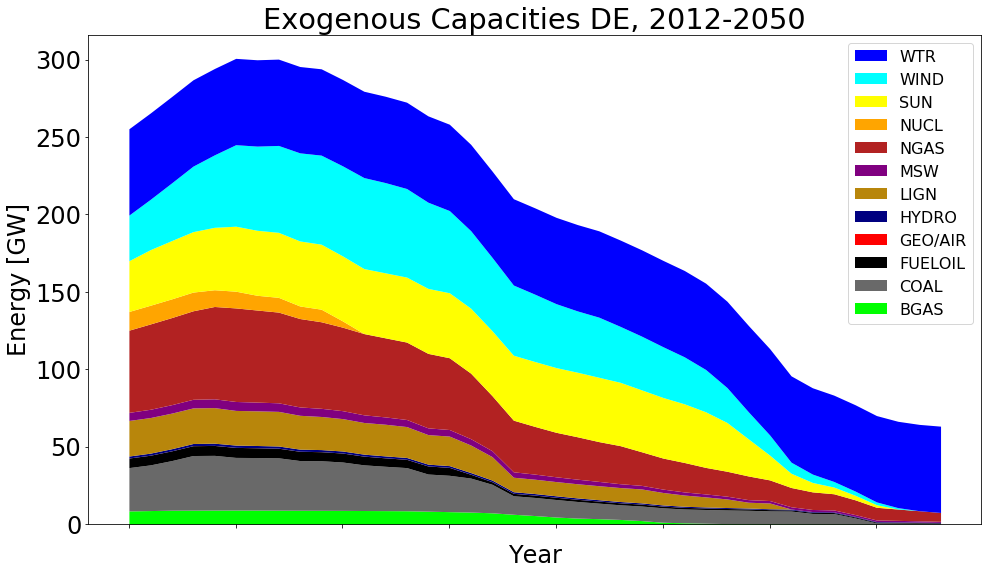

In [279]:
# Prepare data for plotting
DE_total_dev = region_fuel_cap.groupby(['balmorel_fuel']).agg(y)
DE_total_dev.columns = DE_total_dev.columns.droplevel(1)
DE_total_dev = DE_total_dev.transpose()
DE_total_dev.columns.name = None

# Plot
DE_total_dev.plot.area(figsize=(16,9),
                       lw=0,
                       color=DE_total_dev.columns[:].map(lambda x: color_dict.get(x,x)),
                       legend='reverse',
                       stacked=True)

plt.title('Exogenous Capacities DE, 2012-2050')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')

# Save figure
plt.savefig('output/figures/DE_fuel_dev.png', transparent=True, compression=None)
plt.show()

plt.close()

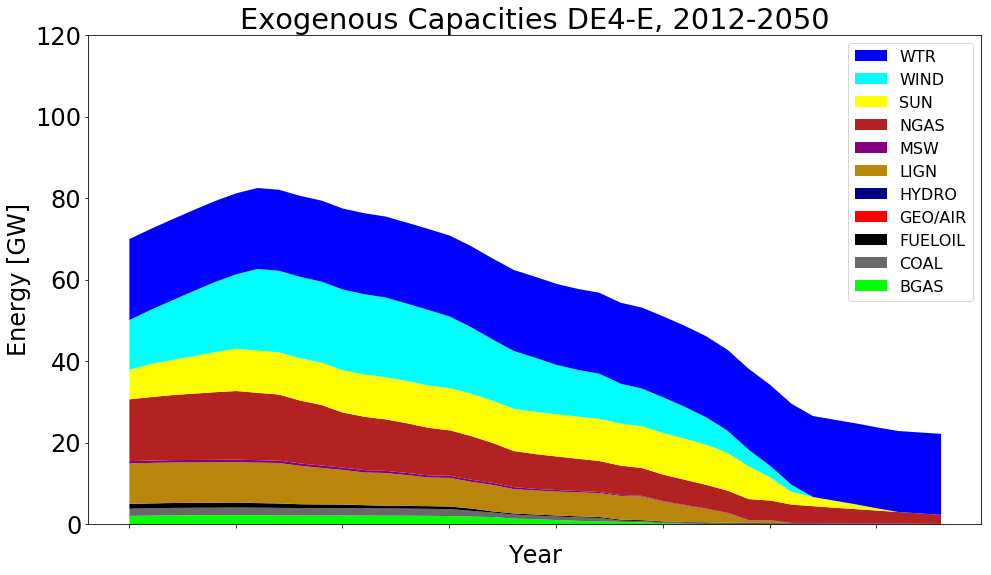

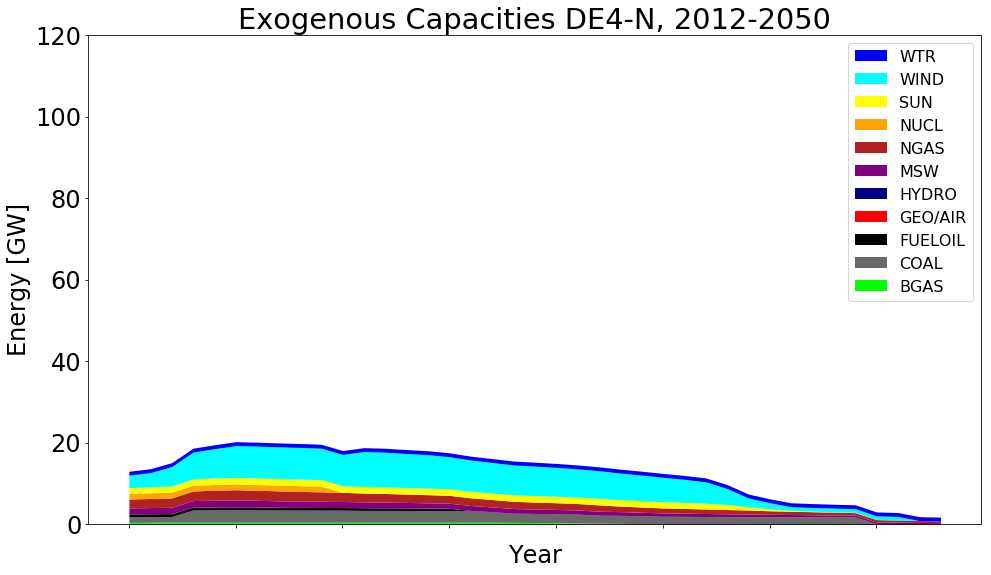

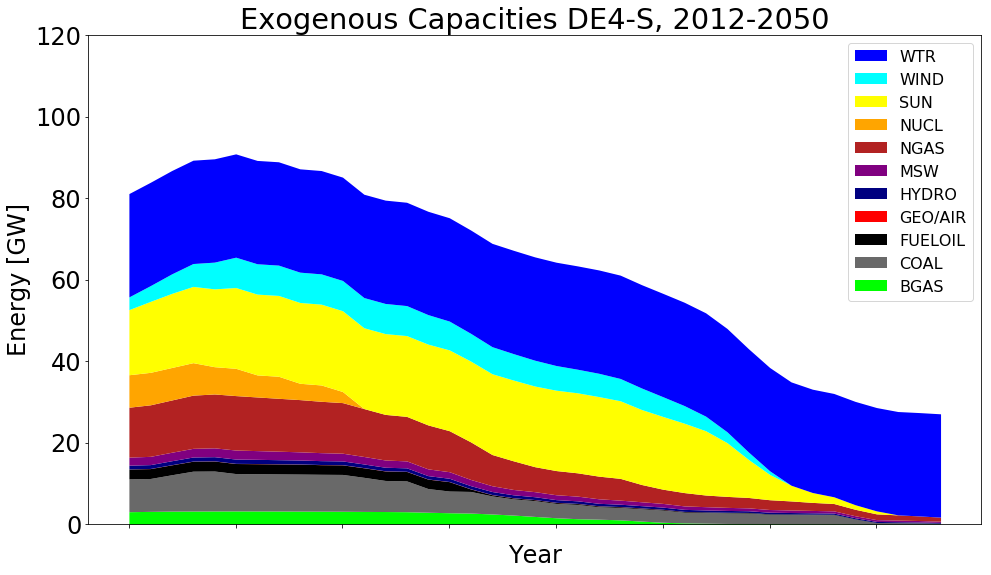

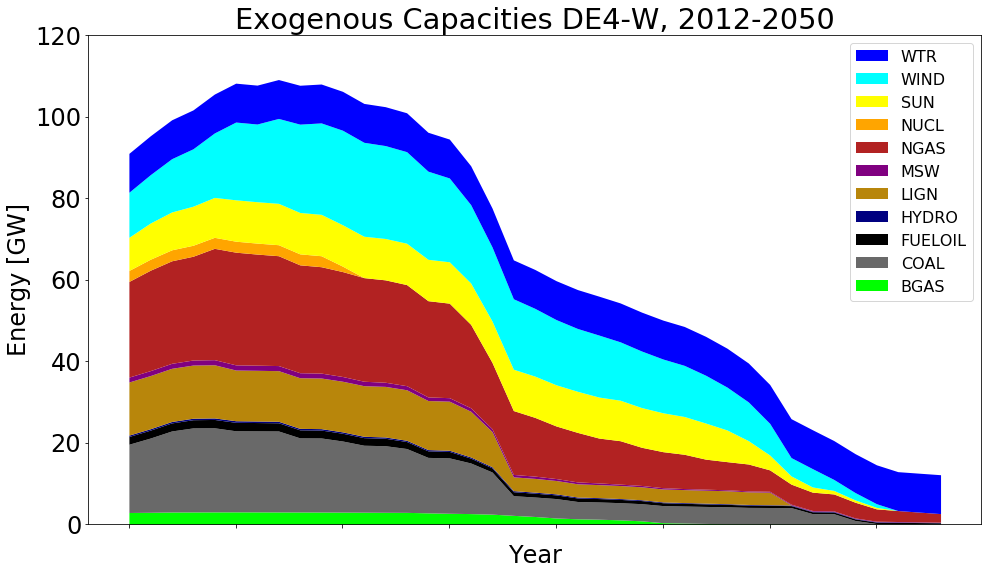

In [280]:
# Plot by regions
for i in list(region_fuel_cap.balmorel_region.unique()):
    plt.close()
    DE_region_dev = region_fuel_cap[region_fuel_cap.balmorel_region==i].groupby(['balmorel_fuel']).agg(y)
    DE_region_dev.columns = DE_region_dev.columns.droplevel(1)
    DE_region_dev = DE_region_dev.transpose()
    DE_region_dev.columns.name = None
    DE_region_dev.plot.area(figsize=(16,9),
                            lw=0,
                            color=DE_region_dev.columns[:].map(lambda x: color_dict.get(x,x)),
                            legend='reverse',
                            stacked=True)
    plt.ylim([0, region_fuel_cap.groupby(['balmorel_region']).agg(y).max(axis=1).max() * 1.1])
    plt.title('Exogenous Capacities {}, 2012-2050'.format(i))
    plt.xlabel('Year')
    plt.ylabel('Energy [GW]')
    
    # Save figure
    plt.savefig('output/figures/{}_region_fuel_dev.png'.format(i), transparent=True, compression=None)
    plt.show()
    
plt.close()

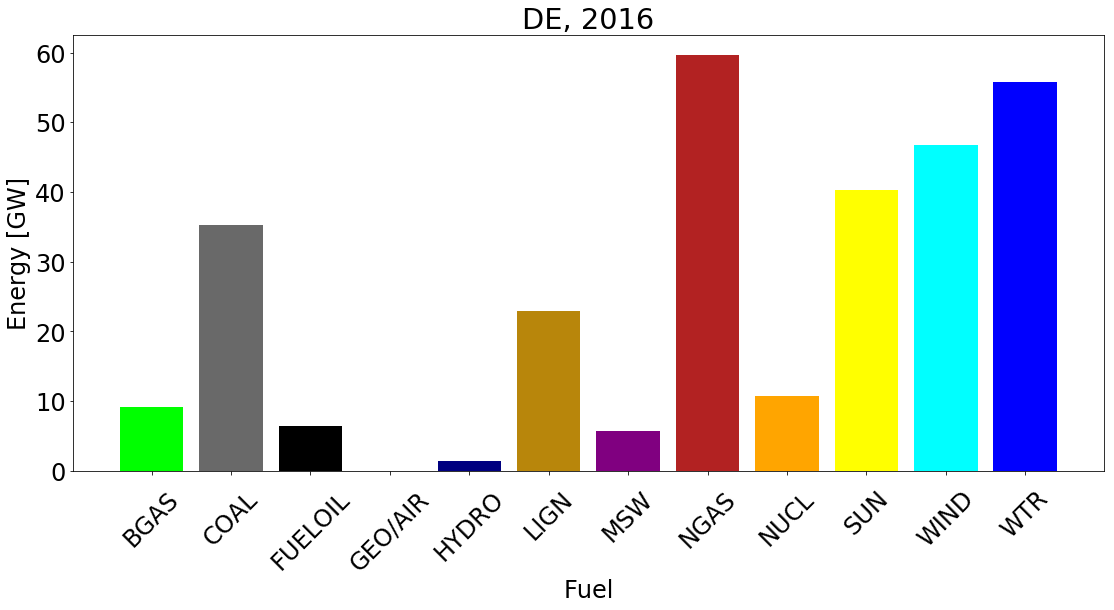

In [281]:
# Prepare data for plotting
region_fuel_cap_2016 = region_fuel_cap.groupby(['balmorel_fuel'])['2016'].sum()
region_fuel_cap_2016 = pd.DataFrame(region_fuel_cap_2016)
region_fuel_cap_2016['colors'] = region_fuel_cap_2016.index


# Plot
fig = plt.figure(figsize=(16, 9))

DE_2016_bar = plt.bar(region_fuel_cap_2016.index,
                      region_fuel_cap_2016['2016'],
                      color=region_fuel_cap_2016['colors'].map(lambda x: color_dict.get(x, x)))
plt.title('DE, 2016')
plt.xlabel('Fuel')
plt.ylabel('Energy [GW]')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
plt.close()

# Save figure
fig.savefig('output/figures/DE_2016_bar.png', transparent=True, compression=None)

plt.close()

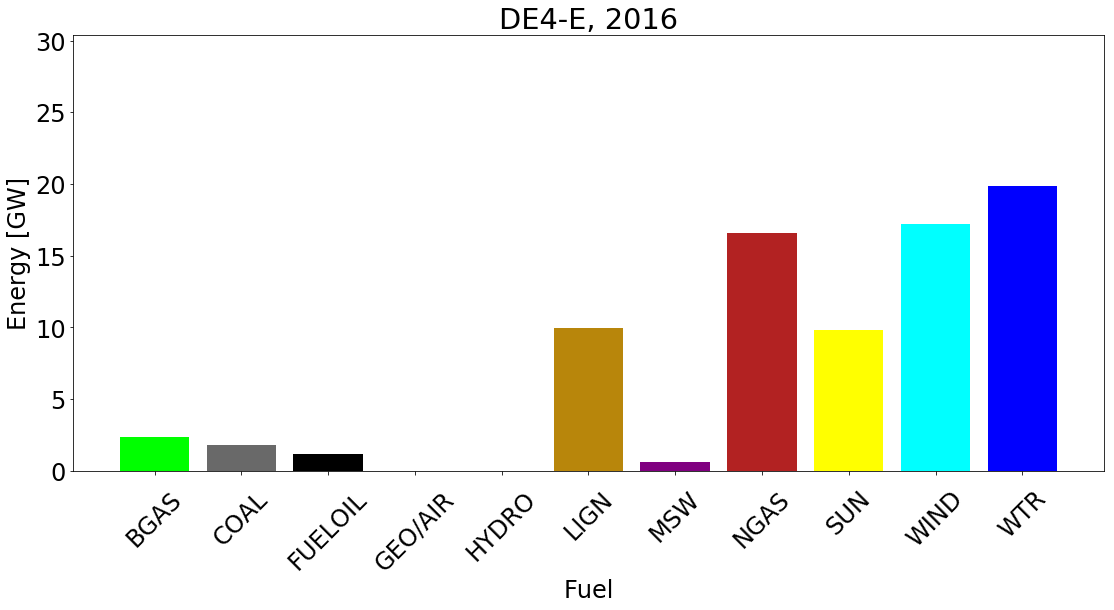

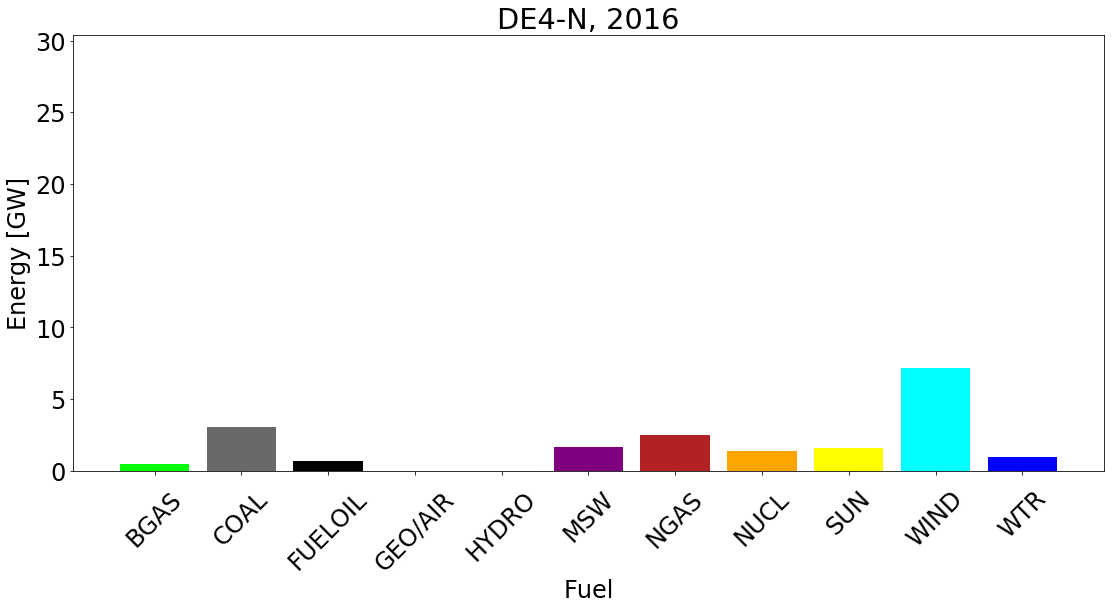

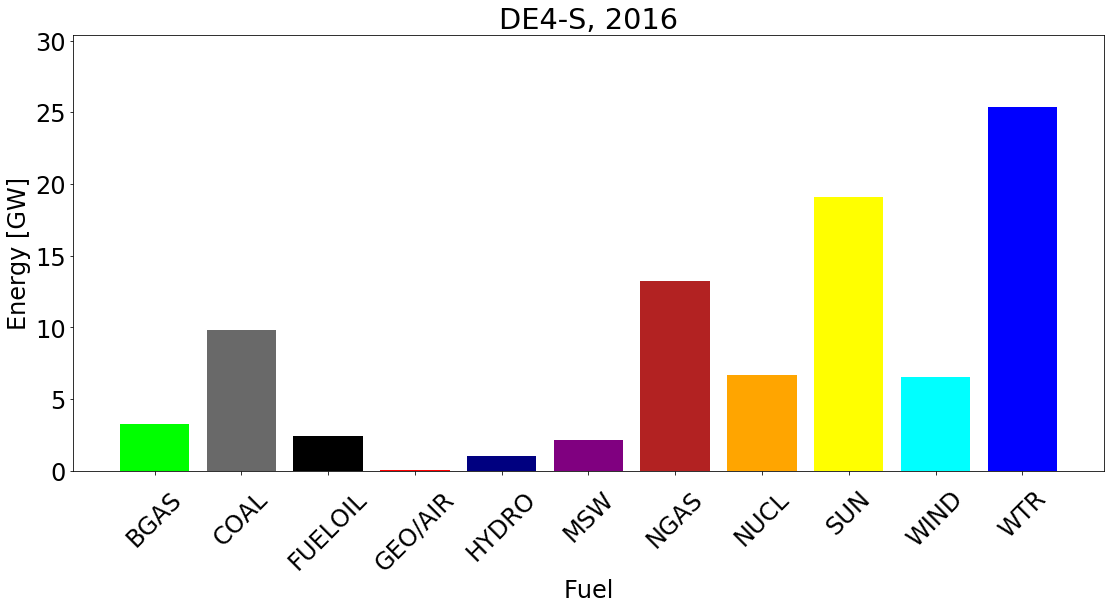

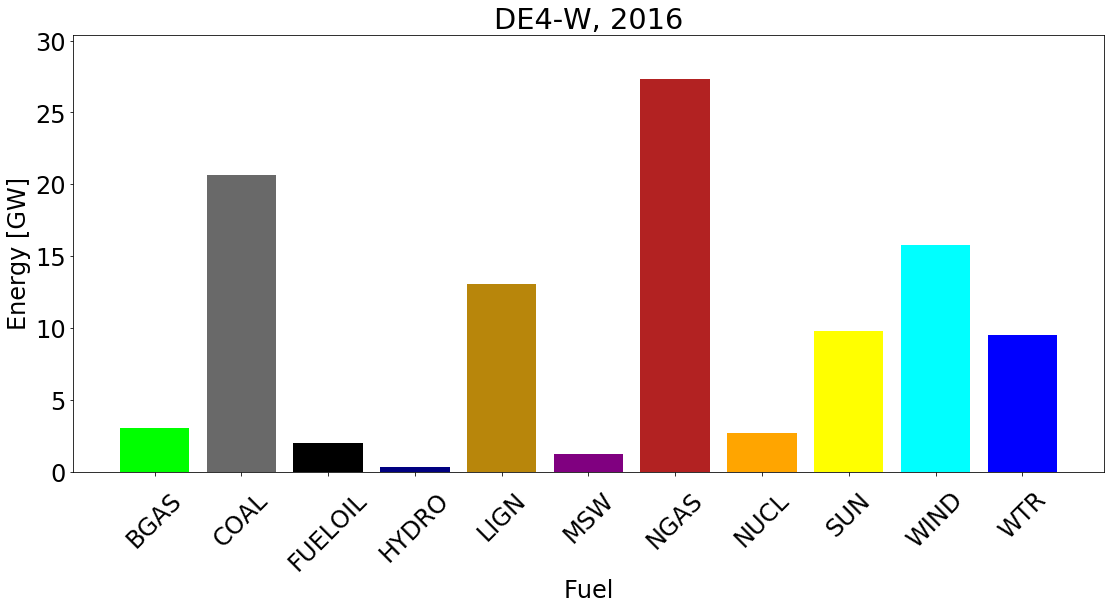

In [282]:
# Prepare data for plotting
region_total_bar = region_fuel_cap.groupby(['balmorel_region', 'balmorel_fuel']).agg(y)
region_total_bar.columns = region_total_bar.columns.droplevel(1)
region_total_bar['colors'] = region_total_bar.index.get_level_values(1)
region_total_bar = region_total_bar.assign(colors = region_total_bar.loc[:,'colors'].map(lambda x: color_dict.get(x,x)))

# Specifications for each plot
regions = region_total_bar.index.get_level_values('balmorel_region').unique()
yr = '2016'

# Create a folder for the graphs
if not os.path.isdir('output/figures/' + region_choice):
    os.makedirs('output/figures/' + region_choice)

# Plot
fig, ax = plt.subplots()

for region,num in zip(regions, range(1,len(regions) + 1)):
    plt.close()
    ax = fig.add_subplot(len(regions),1,num)
    df = region_total_bar.xs(region)[yr]
    df = pd.DataFrame(df)
    df['colors'] = df.index
    plt.subplots(figsize=(16,9))
    plt.bar(df.index,
            df[yr],
            color=df.colors.map(lambda x: color_dict.get(x, x)))
    plt.xlabel('Fuel')
    plt.ylabel('Energy [GW]')
    plt.xticks(rotation=45)
    plt.title(region + ', ' + yr)
    plt.ylim([0,max(region_total_bar.max(axis=1)) * 1.1])
    plt.tight_layout()
    
    # Save figure
    plt.savefig('output/figures/' + region_choice + '/region_' + region + '_2016_bar.pdf')
    plt.show()
    
plt.close()

## Clean-Up for Final Output

In [283]:
# Formatting efficiency values and merging technology, fuel and counter into one column
con['balmorel_eff'] = con['eff_w_mean'] * 100
con['balmorel_eff'] = con['balmorel_eff'].astype(int)
ren['balmorel_eff'] = ren['efficiency'] * 100
ren['balmorel_eff'] = ren['balmorel_eff'].astype(int)
off_fut['balmorel_eff'] = off_fut['efficiency'].astype(int) * 100
ho_fuel['balmorel_eff'] = ho_fuel['average_efficiency_2017'] * 100
ho_fuel['balmorel_eff'] = ho_fuel['balmorel_eff'].astype(int)

In [284]:
# efficiency dict for heat only
dict_ho_eff = ho_fuel.groupby(['balmorel_fuel'])['balmorel_eff'].agg('mean').to_dict()

# and make eff column in ho dataframe
ho['balmorel_eff'] = ho.balmorel_fuel
ho['balmorel_eff'] = ho['balmorel_eff'].replace(dict_ho_eff)

In [285]:
# Renaming the column names
con['Technology'] = np.where((con['balmorel_tec_type'] != '-'),
                             (con['balmorel_tec_group'] + '_' + con['balmorel_fuel'] + '_' +
                              con['balmorel_tec_type'] + '_E-' + con['balmorel_eff'].map(str)),
                             (con['balmorel_tec_group'] + '_' + con['balmorel_fuel'] +
                              '_E-' + con['balmorel_eff'].map(str)))

ren['Technology'] = np.where((ren['balmorel_tec_type'] != '-'),
                             (ren['balmorel_tec_group'] + '_' + ren['balmorel_fuel'] + '_' +
                              ren['balmorel_tec_type'] + '_E-' + ren['balmorel_eff'].map(str)),
                             (ren['balmorel_tec_group'] + '_' + ren['balmorel_fuel'] +
                              '_E-' + ren['balmorel_eff'].map(str)))

off_fut['Technology'] = 'GNR_' + off_fut['balmorel_tec_group'] + '_' + off_fut['balmorel_fuel'] + '_' + off_fut['balmorel_tec_type']

ho['Technology'] = 'GNR_' + 'BO_' + ho['balmorel_fuel'] + '_E-' + ho['balmorel_eff'].map(str)

In [286]:
# Renewable power plant efficiencies will not be containt in the technology name
con['Technology'] = np.where((con.balmorel_fuel == 'WTR'),
                             (con['Technology'].str.rsplit('_E', 1).str.get(0)),
                             (con['Technology']))

ren['Technology'] = np.where((ren.balmorel_fuel == 'SUN') |
                             (ren.balmorel_fuel == 'WTR') |
                             (ren.balmorel_fuel == 'WIND') |
                             (ren.balmorel_fuel == 'ELEC') |
                             (ren.balmorel_tec_group == 'GEO'),
                             (ren['Technology'].str.rsplit('_E', 1).str.get(0)),
                             (ren['Technology']))

In [287]:
# Reservoirs with pumping and electrical storages get a specified name
con['Technology'] = np.where((con.balmorel_tec_type == 'PMP'),
                             ('AGG-' + con['balmorel_region'] + '_' + con['Technology']),
                             ('GNR_' + con['Technology']))

ren['Technology'] = np.where((ren.balmorel_tec_group == 'ES'),
                             ('AGG-' + ren['balmorel_region'] + '_' + ren['Technology']),
                             ('GNR_' + ren['Technology']))

In [288]:
# Make new columns for area and dot
con['Area'] = con['balmorel_region']
con[''] = '.'

ren['Area'] = ren['balmorel_region']
ren[''] = '.'

off_fut['Area'] = off_fut['balmorel_region']
off_fut[''] = '.'

ho['Area'] = ho['balmorel_region']
ho[''] = '.'

In [289]:
# Select relevant columns with index
idx =  ['Area'] + [''] + ['Technology'] + ['{}'.format(i) for i in years]

con = con[idx]
ren = ren[idx]
off_fut = off_fut[idx]
ho = ho[idx]

In [290]:
# Create a new dataframe
capacities_DE = con.append(ren, ignore_index=True)
capacities_DE = capacities_DE.append(off_fut, ignore_index=True)
capacities_DE = capacities_DE.append(ho, ignore_index=True)
capacities_DE = capacities_DE.sort_values(['Area'])

In [291]:
# Assign new areas to the offshore capacities
capacities_DE['Area'] = np.where(capacities_DE['Technology'].str.contains('OFF')==True,
                                 capacities_DE['Area'].astype(str) + '_Offshore',
                                 capacities_DE['Area'])

## G Output
It contains all the unique technology names of capacities_DE

In [292]:
# Select relevant columns for G with index
idx_g = ['Technology']

# Create new dataframes with index
DE_G = capacities_DE[idx_g]

In [293]:
# Sort by technology names, drop duplicates and reset the index
DE_G = DE_G.sort_values(['Technology'])
DE_G.drop_duplicates(inplace=True)
DE_G.reset_index(drop=True, inplace=True)

In [294]:
# Write DE_G to csv file
DE_G.to_csv('output/tables/DE_G.csv', encoding='utf8')

# Write DE_G to xls file
DE_G.to_excel('output/tables/DE_G.xlsx', encoding='utf8')

## GKFX Output

In [295]:
# Append an 'A' to the Area name tail
capacities_DE.Area = np.where(capacities_DE.Area.str.contains('Offshore')==False,
                              capacities_DE.Area + '_A',
                              capacities_DE.Area)

In [296]:
# Round capacities to requiered number of decimal places
decimal_choice = 2
capacities_DE = capacities_DE.round(decimal_choice)
capacities_DE.columns = capacities_DE.columns.droplevel(1)

In [297]:
# Sum an d aggregate capacities
capacities_DE = capacities_DE.groupby(['Area','','Technology']).agg(y)
capacities_DE = pd.DataFrame(capacities_DE)
capacities_DE.reset_index(inplace=True)
capacities_DE.columns = capacities_DE.columns.droplevel(1)

In [298]:
# Write a csv file
capacities_DE.to_csv('./output/tables/DE_GKFX_{}.csv'.format(region_choice), encoding='utf8')

# Write a excel file
capacities_DE.to_excel('./output/tables/DE_GKFX_{}.xlsx'.format(region_choice), encoding='utf8')

## CCC, RRR, AAA Output

In [299]:
geography = capacities_DE[['Technology','Area']]

In [300]:
# make a new dataframe for CCC, RRR, AAA output
geography = pd.DataFrame()
geography['AAA'] = capacities_DE['Area']
geography['RRR'] = geography['AAA'].str.split('_').str.get(0)
geography['CCC'] = 'GERMANY'

In [301]:
# AAA
AAA = geography[['AAA']]
AAA = AAA.drop_duplicates()
AAA.to_csv('output/tables/AAA_DE.csv', encoding='utf8')
AAA.to_excel('output/tables/AAA_DE.xlsx', encoding='utf8')

# RRR
RRR = geography[['RRR']]
RRR = RRR.drop_duplicates()
RRR.to_csv('output/tables/RRR_DE.csv', encoding='utf8')
RRR.to_excel('output/tables/RRR_DE.xlsx', encoding='utf8')

# CCC
CCC = geography[['CCC']]
CCC = CCC.drop_duplicates()
CCC.to_csv('output/tables/CCC_DE.csv', encoding='utf8')
CCC.to_excel('output/tables/CCC_DE.xlsx', encoding='utf8')

# RRRAAA
RRRAAA = geography[['RRR','AAA']]
RRRAAA = RRRAAA.drop_duplicates()
RRRAAA.to_csv('output/tables/RRRAAA_DE.csv', encoding='utf8')
RRRAAA.to_excel('output/tables/RRRAAA_DE.xlsx', encoding='utf8')

# CCCRRR
CCCRRR = geography[['CCC','RRR']]
CCCRRR = CCCRRR.drop_duplicates()
CCCRRR.to_csv('output/tables/CCCRRR_DE.csv', encoding='utf8')
CCCRRR.to_excel('output/tables/CCCRRR_DE.xlsx', encoding='utf8')

# CCCRRRAAA
CCCRRRAAA = pd.Series(geography.values.ravel('F'))
CCCRRRAAA = CCCRRRAAA.drop_duplicates()
CCCRRRAAA.to_csv('output/tables/CCCRRRAAA_DE.csv', encoding='utf8')
CCCRRRAAA.to_excel('output/tables/CCCRRRAAA_DE.xlsx', encoding='utf8')

## Comparison of Results

### Check summed capacities
In order to verify, whether the results of the data processing are in a reasonable range, the yearly stacked generation capacities are compared to three other sources:
1. bnatza values, which are the summed capacities of opsd_con and opsd_ren (upper boundary)
2. flex4res values, which are supposed to be replaced
3. opsd national generation capacity values, which are from the same source as opsd_con and opsd_ren

### Read plotting data
Raw data on national generation capacities available here: https://data.open-power-system-data.org/national_generation_capacity/

In [302]:
# Read stacked capacities from the flex4res and the national generation capacities table
capacity_comparison = pd.read_csv('input/cap_comparison.csv',
                      encoding='utf8',
                      header=0,
                      index_col=0)

# Re-read the original opsd_con table
con_orig = pd.read_csv('input/conventionals.csv',
                      encoding='utf8',
                      header=0)

# Re-read the original opsd_ren table
ren_orig = pd.read_csv('input/renewables.csv',
                      encoding='utf8',
                      header=0,
                      parse_dates=[1],
                      low_memory=False)

### Clean-Up for Plotting

In [303]:
# Drop unnecessary columns
capacities_DE.drop(['', 'Area'], axis=1, inplace=True)

# Select the technology column as the new index
capacities_DE.set_index('Technology', inplace=True)

### Plotting

In [304]:
# Create a folder for the graphs
if not os.path.isdir('output/figures/cap_comparison/'):
    os.makedirs('output/figures/cap_comparison/')

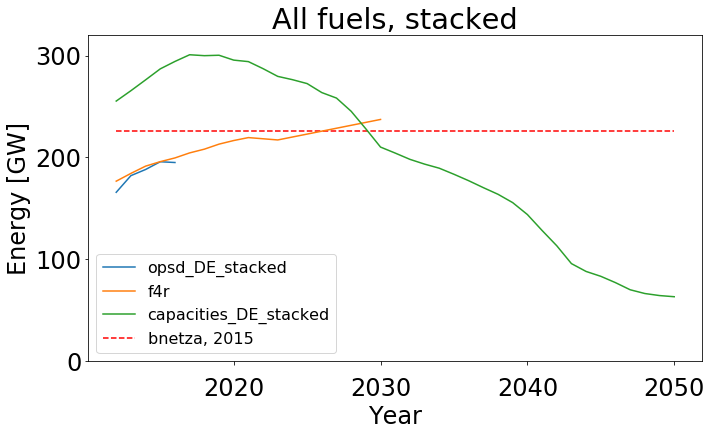

In [305]:
# Sum the yearly capacities and/or re-naming the data sets
capacities_DE_stacked = capacities_DE.sum(axis=0) / 1000

bnetza_2015 = (ren_orig['electrical_capacity'].sum() +
               ren_orig['thermal_capacity'].sum() +
               con_orig['capacity_net_bnetza'].sum()) / 1000

capacities_flex4res = capacity_comparison['Flex4Res'] / 1000

opsd_national_stacked = capacity_comparison.opsd / 1000

# plot
fig = plt.figure(figsize=(11,6))
plt.plot(years, opsd_national_stacked, label='opsd_DE_stacked')
plt.plot(years, capacities_flex4res, label='f4r')
plt.plot(years, capacities_DE_stacked, label='capacities_DE_stacked')
plt.hlines(y=bnetza_2015, xmin=2012, xmax=2050, colors='r', linestyles='--', label='bnetza, 2015')
plt.legend(loc=3)
plt.title('All fuels, stacked')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.ylim([0,320])
plt.show()

# save figure
fig.savefig('output/figures/cap_comparison/comparison_all.pdf')

### Check capacities per fuel
Comparing fuel specific generation capacities between the opsd data and data from the flex4res table.

In [306]:
# Import of fuel specific generation capacities of flex4res
fuel_capacities_flex4res = pd.read_csv('input/cap_comparison_flex4res.csv',
                                      header=0,
                                      encoding='utf8')

# Adjusting the dataframe
fuel_capacities_flex4res.set_index('Technology', inplace=True)
fuel_capacities_flex4res.index.astype(str);

#### BIOGAS/WOOD

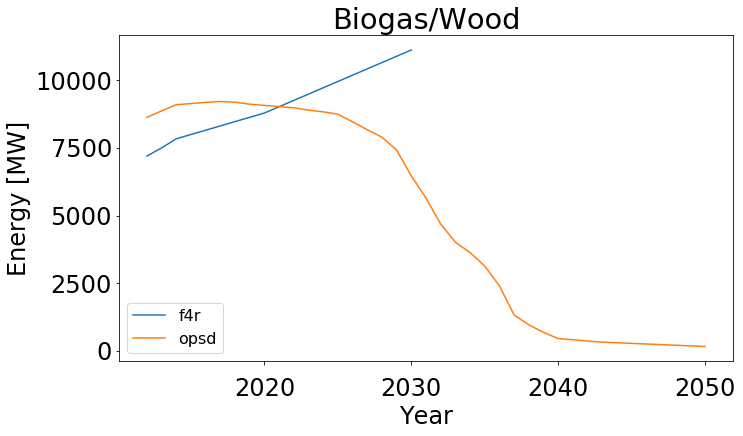

In [307]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19], fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('WOOD')].sum(), label='f4r')
plt.plot(years, capacities_DE[capacities_DE.index.str.contains('BGAS')].sum(), label='opsd')
plt.legend(loc=3)
plt.title('Biogas/Wood')
plt.xlabel('Year')
plt.ylabel('Energy [MW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_BGAS.pdf')

#### COAL

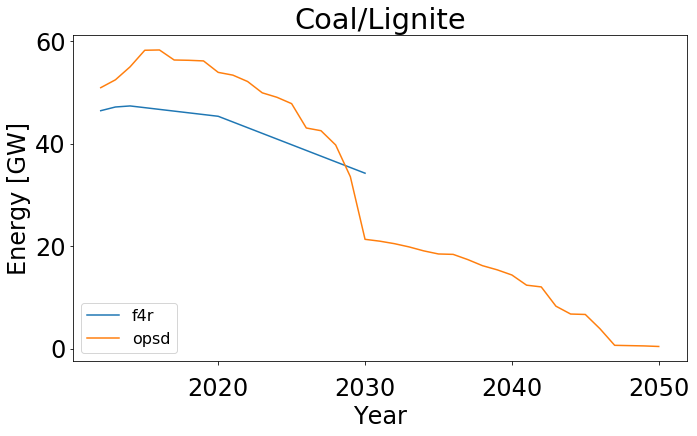

In [308]:
# Create filter
searchfor = ['COAL', 'LIGNITE']

# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('|'.join(searchfor))].sum() / 1000,
         label='f4r')
plt.plot(years, capacities_DE[capacities_DE.index.str.contains('COAL|LIGN')].sum() / 1000, label='opsd')
plt.legend(loc=3)
plt.title('Coal/Lignite')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_COAL.pdf')

#### FUELOIL

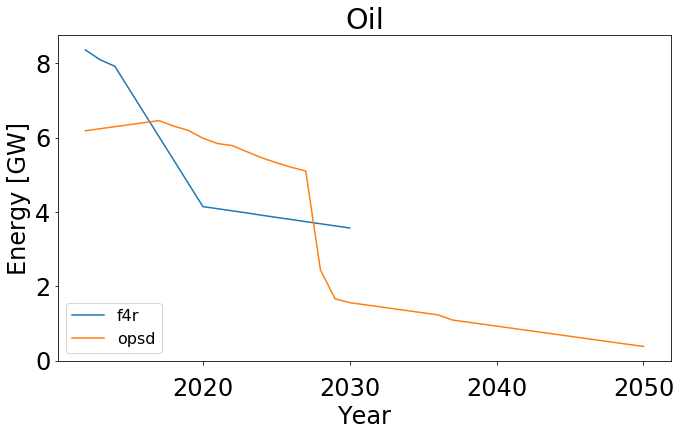

In [309]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('FUELOIL')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('FUELOIL')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Oil')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_FUELOIL.pdf')

#### MUNIWASTE

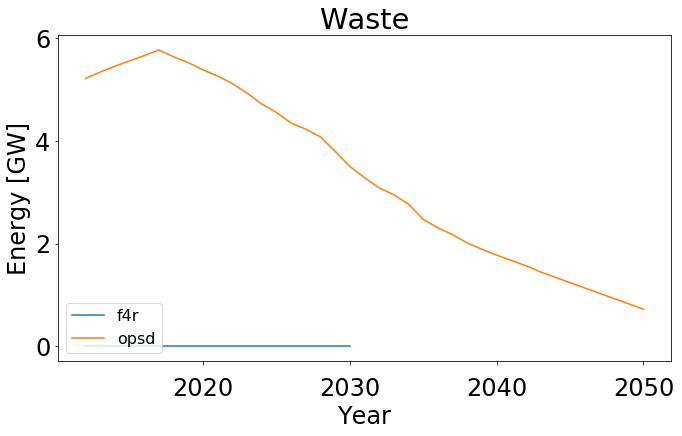

In [310]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('MUNIWASTE')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('MSW')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Waste')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_MSW.pdf')

#### NATGAS

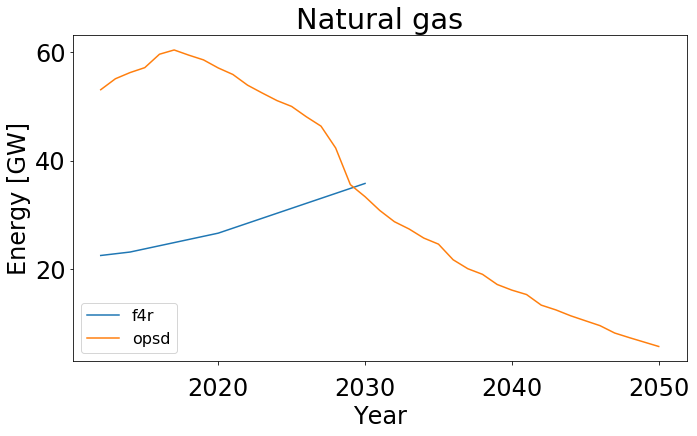

In [311]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('NATGAS')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('NGAS')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Natural gas')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_NGAS.pdf')

#### NUCLEAR

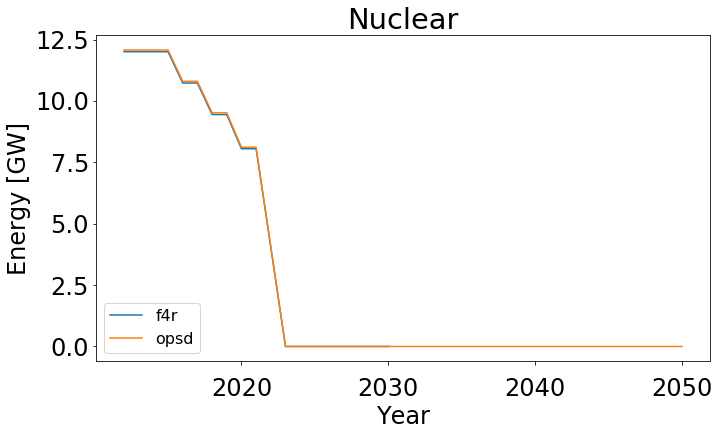

In [312]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('NUCLEAR')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('NUCL')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Nuclear')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_NUCL.pdf')

#### SUN

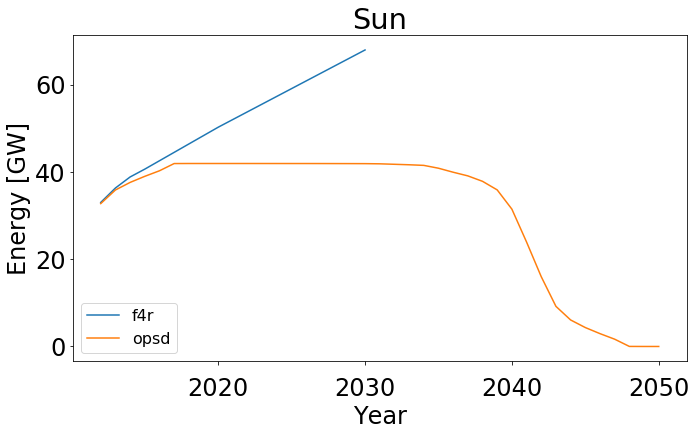

In [313]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('SUN')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('SUN')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Sun')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_SUN.pdf')

#### WATER

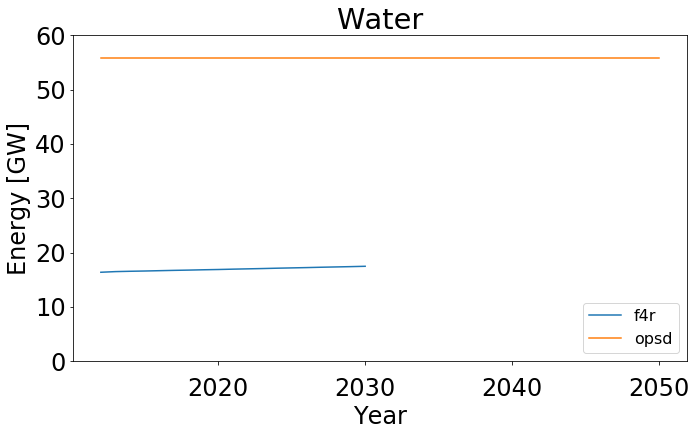

In [314]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('WATER')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('WTR|PMP')].sum() / 1000,
         label='opsd')
plt.legend(loc=4)
plt.title('Water')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.ylim([0,60])
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_WTR.pdf')

# comment: comparing MW (f4r) and MWh (opsd)!

#### WIND

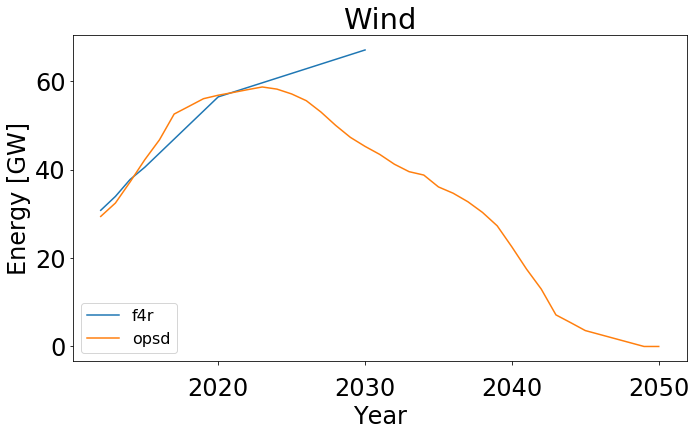

In [315]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('WIND')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('WIND')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Wind')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_WIND.pdf')

#### GEOTHERMAL

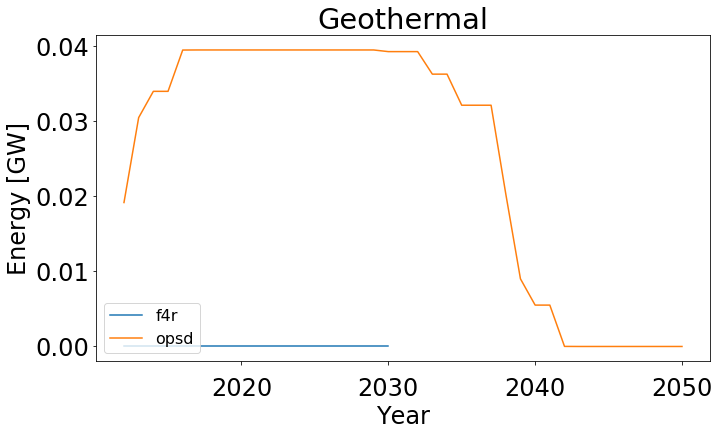

In [316]:
# Plot
fig = plt.figure(figsize=(11,6))
plt.plot(years[0:19],
         fuel_capacities_flex4res[fuel_capacities_flex4res.index.str.contains('GEO')].sum() / 1000,
         label='f4r')
plt.plot(years,
         capacities_DE[capacities_DE.index.str.contains('GEO')].sum() / 1000,
         label='opsd')
plt.legend(loc=3)
plt.title('Geothermal')
plt.xlabel('Year')
plt.ylabel('Energy [GW]')
plt.show()

# Save figure
fig.savefig('output/figures/cap_comparison/comparison_GEO.pdf')